In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

# Question 1 Exploratory Data Analysis

* From example/input/ load compustat.csv inside compustat.zip  without unzip compustat.zip

In [2]:
import zipfile
z = zipfile.ZipFile("example/input/compustat.zip", "r")
f = z.open("compustat.csv")
stat = pd.read_csv(f)
f.close()

In [3]:
stat.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,cusip,curcdq,datacqtr,datafqtr,cshoq,saleq,costat,prccq,sic
0,1000,19660331,1966,1,INDL,C,D,STD,000032102,USD,1966Q1,1966Q1,0.219,NaN,I,NaN,3089.0
1,1000,19660630,1966,2,INDL,C,D,STD,000032102,USD,1966Q2,1966Q2,0.219,NaN,I,NaN,3089.0
2,1000,19660930,1966,3,INDL,C,D,STD,000032102,USD,1966Q3,1966Q3,0.219,NaN,I,NaN,3089.0
3,1000,19661231,1966,4,INDL,C,D,STD,000032102,USD,1966Q4,1966Q4,0.219,4.032,I,NaN,3089.0
4,1000,19670331,1967,1,INDL,C,D,STD,000032102,USD,1967Q1,1967Q1,0.277,NaN,I,NaN,3089.0


* 1. Variable names that we are interested in:
    * sic code: four digits integer for company
    * datecqtr: year/ quarter time for the record
    * cusip: compustats identifier for a company
    * chod: shares out of standing (in million)
    * saleq: sales of current quarter (in million)
    * prccq: close price of current quarter (in dollar)

In [4]:
stat = stat[["sic", "datacqtr", "cusip", "cshoq", "saleq", "prccq"]]
stat.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq
0,3089.0,1966Q1,000032102,0.219,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN


* 2. For saleq and market cap, compute the following:
    * Time series mean 
    * Time Series standard deviation
    * Time Series count of missing values
    * Time Series ratio of missing values
    * Aggregate the result in a dataframe

In [5]:
# Add market cap
stat["mkt_cap"] = stat["cshoq"]*stat["prccq"]
stat.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq,mkt_cap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [6]:
def get_stats(data):
    num_nan = int(data.isna().sum())
    return pd.Series([data.mean(), data.std(), num_nan, num_nan/len(data)], index = ["mean", "standard deviation", "count of missing values", "ratio of missing values"])

In [7]:
stat[["saleq", "mkt_cap"]].apply(get_stats).applymap(lambda x: '%.2f' % x)

,saleq,mkt_cap
mean,445.15,2057.47
standard deviation,2679.71,13202.20
count of missing values,269498.00,468276.00
ratio of missing values,0.15,0.26


* 3. Answer the following questions:

__a) Before computing any value, what kinds of descriptive analysis would you do to check if there are outliers?__

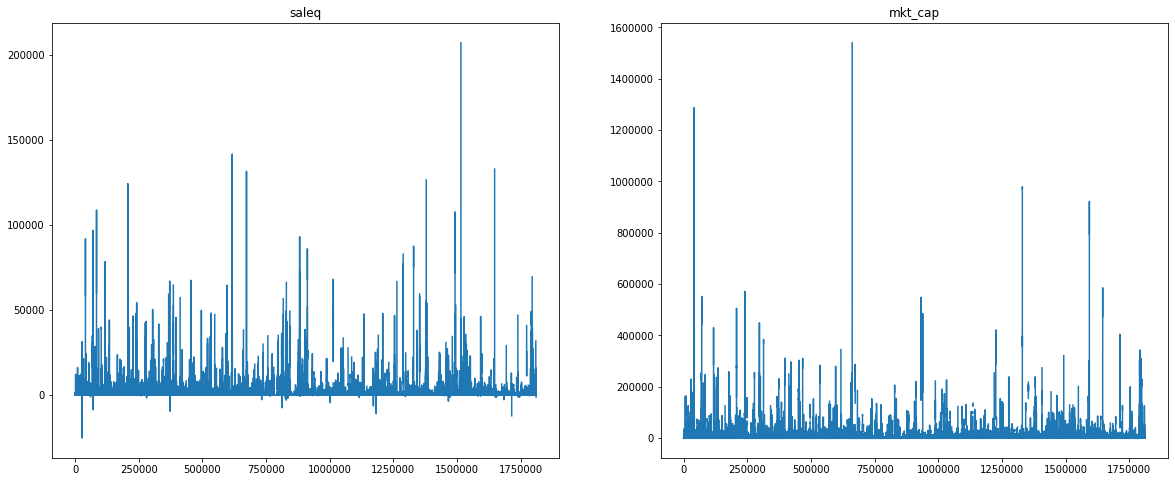

In [8]:
# We can draw plots to visualize outliers.
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(20,8))
plt.subplot(121)
plt.title("saleq")
plt.plot(stat["saleq"])
plt.subplot(122)
plt.title("mkt_cap")
plt.plot(stat["mkt_cap"])
plt.show()

In [9]:
# We can also describe the data.
print(stat["saleq"].describe())
print()
print(stat["mkt_cap"].describe())
# We can see the huge difference between quantile points and min/max, suggesting the existence of outliers.

count    1.541801e+06
mean     4.451507e+02
std      2.679707e+03
min     -2.562300e+04
25%      3.210000e+00
50%      2.182500e+01
75%      1.305300e+02
max      2.073073e+05
Name: saleq, dtype: float64

count    1.343023e+06
mean     2.057473e+03
std      1.320220e+04
min      0.000000e+00
25%      2.000701e+01
50%      9.421800e+01
75%      5.257138e+02
max      1.540774e+06
Name: mkt_cap, dtype: float64


__b) Implement some schemes to detect outliers.__

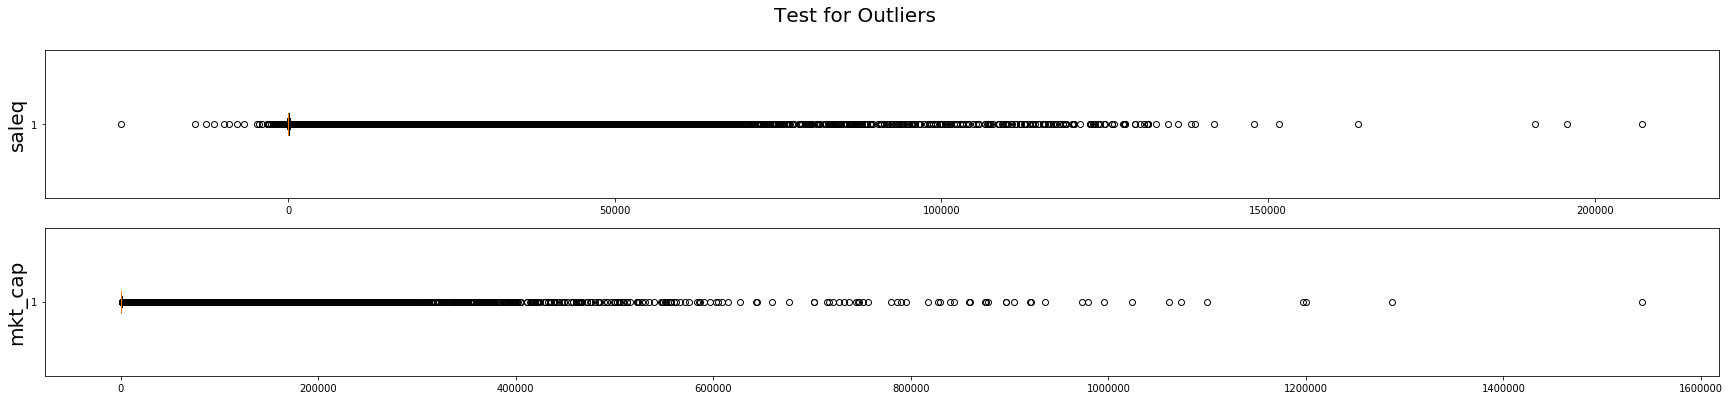

In [10]:
# Use boxplot to detect outliers.
fig = plt.figure(figsize =(30,6))
fig.suptitle("Test for Outliers", fontsize=20)
plt.subplot(211)
plt.boxplot(stat["saleq"].dropna(), sym="o", vert=False)
plt.ylabel("saleq", fontsize=20)
plt.subplot(212)
plt.boxplot(stat["mkt_cap"].dropna(), sym="o", vert=False)
plt.ylabel("mkt_cap", fontsize=20)
plt.show()

__c) Do you find some outliers? Could you think why? You can do some research using google.__

* There are awfully many outliers.
* Reason:
    * We are testing here outliers whose values are over Q3+1.5IQR or under Q1－1.5IQR, which might not be a good choice for this scenario;
    * Companies(Industries) can vary a lot, and some companies(industries) can outperform others by a really large margin;
    * Both saleq and mkt_cap can shift violently during extreme periods, like financial crisis.

__d) What kinds of conclusion you can get from analyzing the table you get in 2? You can make some plots to illustrate.__

Descriptive tables of the data suggest long right tail, as demonstrated by the boxplot.

# Question 2 Compute Industry Concentration

The defination of HHI index could be found: 

https://www.investopedia.com/terms/h/hhi.asp#:~:text=The%20Herfindahl%2DHirschman%20Index%20(HHI)%20is%20a%20commonly%20accepted,close%20to%20zero%20to%2010%2C000.

This index is used to measure the industry concentration and was used by congressman to determine whether to approve a merge deal or not.

Using the same data in question 1. Compute a panel data for HHI index for all industry, using a 2 digit SIC code.

In [11]:
new_stat = stat[['sic','datacqtr','mkt_cap']].copy().dropna()
new_stat['industry'] = new_stat['sic'] // 100
new_stat['mkt_cap_ind']= new_stat.groupby(['industry', 'datacqtr']).mkt_cap.transform('sum')

In [12]:
new_stat['mkt_share_2'] = 10000 * ((new_stat['mkt_cap'] / new_stat['mkt_cap_ind']) ** 2)
new_stat = new_stat[['industry','datacqtr','mkt_share_2']]

In [13]:
statHHI = new_stat.groupby(['industry', 'datacqtr']).sum().rename(columns={'mkt_share_2':'HHI'})
statHHI.head()

HHI
industry datacqtr              
1.0      1967Q4    10000.000000
         1968Q1    10000.000000
         1968Q2     5667.833632
         1968Q3     5927.306594
         1968Q4     3414.368239

Choose top 4 industry with the highest average HHI index, plot their time series pattern of HHI in a 2 by 2 figure.

In [14]:
avg_statHHI = statHHI.groupby(['industry']).mean()
avg_statHHI = avg_statHHI[avg_statHHI['HHI'] < 10000]
avg_statHHI.sort_values(ascending=False, by='HHI', inplace=True)
avg_statHHI.head()

,HHI
industry,
81.0,9362.460875
9.0,9237.889784
84.0,9200.079235
7.0,8247.612978
41.0,7460.903331


In [15]:
# Industries chosen
inds = [int(avg_statHHI.index[i]) for i in range(4)]
inds

[81, 9, 84, 7]

In [16]:
statHHI.reset_index(inplace = True)

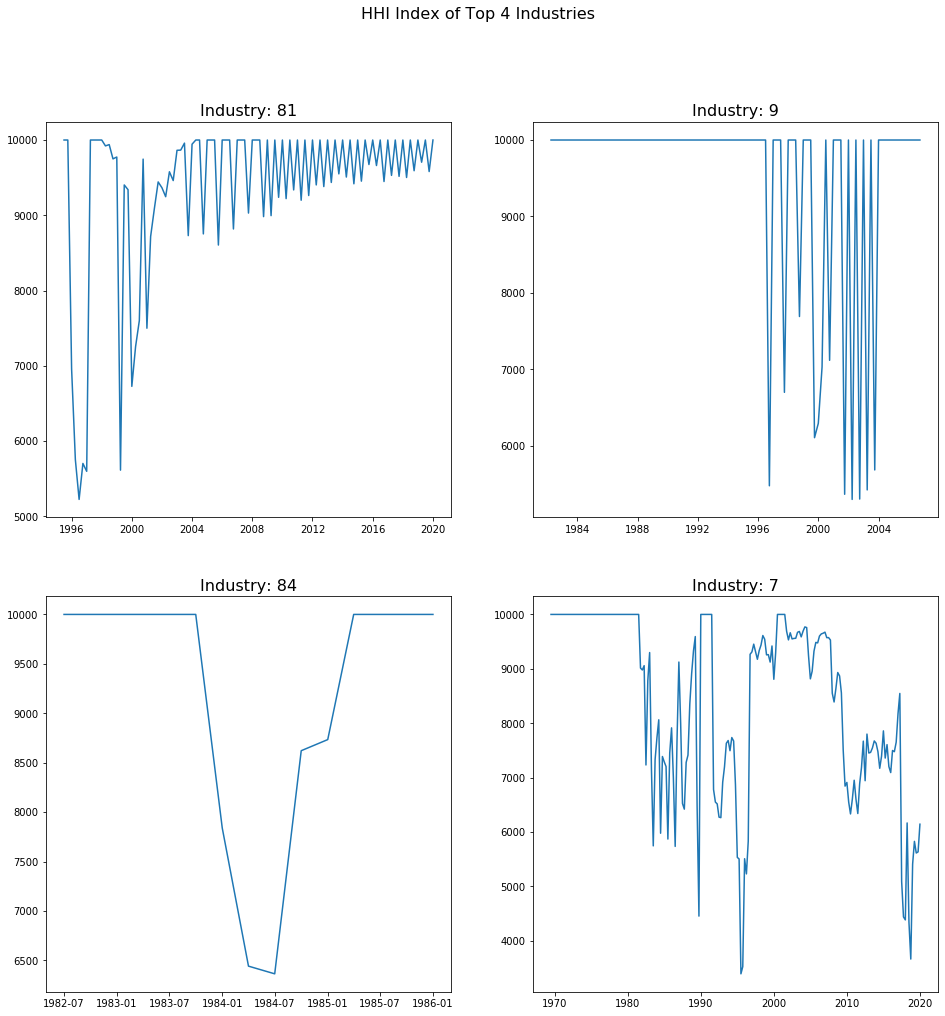

In [17]:
position = [(0,0),(0,1),(1,0),(1,1)]
fig = plt.figure(figsize=(16,16)) 
axes = fig.subplots(2,2)
fig.suptitle('HHI Index of Top 4 Industries', fontsize=16)
for i, ind in enumerate(inds):
    x = position[i][0]
    y = position[i][1]
    data = statHHI[statHHI['industry'] == ind]
    t = pd.to_datetime(data['datacqtr'].str[:4] + data['datacqtr'].str[4:6])
    axes[x, y].plot(t, data['HHI'])
    axes[x, y].set_title(label='Industry: ' + str(ind), fontsize = 16)